In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install transformers datasets evaluate -q

import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # ← هنا من torch مش transformers
from transformers import (
    VisionEncoderDecoderModel,
    ViTFeatureExtractor,
    AutoTokenizer
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Using device: cpu


In [4]:

captions_file = "/kaggle/input/flickr8k/captions.txt"
data = []
with open(captions_file, "r") as f:
    next(f)  
    for line in f:
        parts = line.strip().split(",")
        if len(parts) > 1:
            img, caption = parts[0], ",".join(parts[1:]).strip()
            data.append([img, caption])

df = pd.DataFrame(data, columns=["image", "caption"])
print(df.head(10))
print("cap num:", len(df))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/flickr8k/captions.txt'

In [ ]:
# split 80% train, 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

train_df.to_csv("train_captions.csv", index=False)
test_df.to_csv("test_captions.csv", index=False)


Train size: 32364
Test size: 8091


In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, dataframe, tokenizer, feature_extractor, img_dir, max_len=32):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.img_dir = img_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.img_dir, row["image"])
        image = Image.open(image_path).convert("RGB")


        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze()
        encodings = self.tokenizer(
            row["caption"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = encodings.input_ids.squeeze()
        attention_mask = encodings.attention_mask.squeeze()

        return pixel_values, labels, attention_mask


In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer


In [ ]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# pad_token fix
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


In [ ]:
train_df_small = train_df.sample(2000, random_state=42).reset_index(drop=True)
test_df_small = test_df.sample(500, random_state=42).reset_index(drop=True)

img_dir = "/kaggle/input/flickr8k/Images"

train_dataset = FlickrDataset(train_df_small, tokenizer, feature_extractor, img_dir)
test_dataset = FlickrDataset(test_df_small, tokenizer, feature_extractor, img_dir)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)
EPOCHS = 3

num_training_steps = len(train_loader) * EPOCHS
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    for step, (pixel_values, labels, attention_mask) in enumerate(train_loader):
        pixel_values, labels, attention_mask = (
            pixel_values.to(device),
            labels.to(device),
            attention_mask.to(device)
        )

        outputs = model(
            pixel_values=pixel_values,
            labels=labels,
        )
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        if (step + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Step {step+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished, Avg Loss: {avg_loss:.4f}")


Epoch 1 finished, Avg Loss: 0.8849
Epoch 2 finished, Avg Loss: 0.7819
Epoch 3 finished, Avg Loss: 0.6878


In [ ]:
model.eval()
val_loss = 0

with torch.no_grad():
    for pixel_values, labels, attention_mask in test_loader:
        pixel_values, labels, attention_mask = (
            pixel_values.to(device),
            labels.to(device),
            attention_mask.to(device)
        )
        outputs = model(pixel_values=pixel_values, labels=labels)
        val_loss += outputs.loss.item()

avg_val_loss = val_loss / len(test_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")


Validation Loss: 1.7610


In [ ]:
save_dir = "./image_caption_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f" Model and tokenizer saved to {save_dir}")


 Model and tokenizer saved to ./image_caption_model


In [ ]:
!ls


image_caption_model	 test_captions.csv
image_caption_model.pth  train_captions.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!ls ./image_caption_model


config.json		model.safetensors	 tokenizer.json
generation_config.json	special_tokens_map.json  vocab.json
merges.txt		tokenizer_config.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!zip -r output_files.zip image_caption_model train_captions.csv test_captions.csv


  adding: image_caption_model/ (stored 0%)
  adding: image_caption_model/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 82%)
  adding: image_caption_model/model.safetensors (deflated 7%)
  adding: image_caption_model/generation_config.json (deflated 40%)
  adding: image_caption_model/merges.txt (deflated 53%)
  adding: image_caption_model/special_tokens_map.json (deflated 81%)
  adding: image_caption_model/tokenizer_config.json (deflated 57%)
  adding: image_caption_model/config.json (deflated 63%)
  adding: image_caption_model/vocab.json (deflated 59%)
  adding: train_captions.csv (deflated 61%)
  adding: test_captions.csv (deflated 61%)


In [ ]:
from kaggle_secrets import UserSecretsClient
from IPython.display import FileLink

FileLink(r'output_files.zip')


/kaggle/working/output_files.zip

In [ ]:
from PIL import Image


In [ ]:
def generate_caption(image_path, max_length=32):
    image = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    output_ids = model.generate(
        pixel_values,
        max_length=max_length,
        do_sample=True,   # sampling بدال beam search
        top_k=50,         # top-k sampling
        top_p=0.95        # nucleus sampling
    )

    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption


test_image = img_dir + "/1000268201_693b08cb0e.jpg"
print("Generated Caption:", generate_caption(test_image))


Generated Caption:  little is out a in house sits a in porch is a of little .


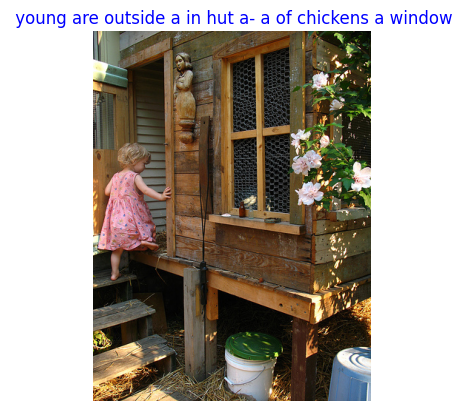

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_captioned_image(image_path, caption):
    img = mpimg.imread(image_path)

    plt.imshow(img)
    plt.axis("off")  
    plt.title(caption, fontsize=12, color="blue")
    plt.show()

test_image = img_dir + "/1000268201_693b08cb0e.jpg"
caption = generate_caption(test_image)
show_captioned_image(test_image, caption)


In [ ]:
pip install --upgrade transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 106.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
Note: you may need to restart the kernel to use updated packages.


In [ ]:
def show_multiple_captions(image_path, max_length=32):
    image = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    greedy_ids = model.generate(pixel_values, max_length=max_length)
    greedy_caption = tokenizer.decode(greedy_ids[0], skip_special_tokens=True)

    sample_ids = model.generate(pixel_values, max_length=max_length, do_sample=True, top_k=50, top_p=0.95)
    sample_caption = tokenizer.decode(sample_ids[0], skip_special_tokens=True)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Greedy: {greedy_caption}\nSampling: {sample_caption}", 
              fontsize=12, color="blue")
    plt.show()

test_image = img_dir + "/1000268201_693b08cb0e.jpg"
show_multiple_captions(test_image)


NameError: name 'img_dir' is not defined